<a href="https://colab.research.google.com/github/Giuseppe0075/PyTorch-Learning/blob/main/01_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch Workflow
1. Data (prepare and load)
2. Build model
3. Fit the model to data
4. Evaluate the model
5. Save and load a model
6. Putting it all togheter

In [47]:
import torch
from torch import nn #nn contains all of PyTorch's building blocks for deep learning
import matplotlib.pyplot as plt

## 1. Data (preparing and loading)

In [48]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

### Splitting data into training and test sets

In [49]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

Data visualization with plt

In [50]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  plt.figure(figsize=(10,7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c='b', s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c='g', s=4, label="Testing data")

  # Are there predictions?
  if predictions is not None:
    plt.scatter(test_data, predictions, c='r', s=4, label="Predictions")

  plt.legend(prop={"size": 14})

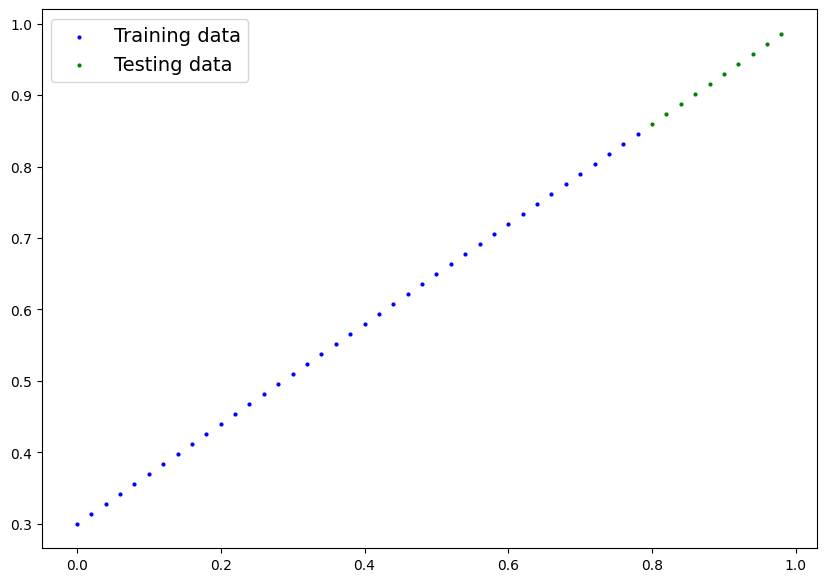

In [51]:
plot_predictions()

##2. Build the model
The model starts with random values (weight & bias) and than look at training data to adjust the random values to better represent the ideal values

How does it do so?
1. Gradient descent
2. Backpropagation

In [52]:
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))

  # Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias


### PyTorch model building essentials

* torch.nn - contains all of the buildings blocks for comptutational graphs
* torch.nn.Parameter - what paprameters should our model try and learn
* torch.nn.Module - the base class for all neural network modules
* torch.optim - contains functions to optimize weights and bias
* forward() - all nn.Module subclasses require to overwrite it. It define what happens in the forward computation


### Checking the contents of our PyTorch model

Let's see what's inside the model.
We can check our model parameters or what's inside our model using `.parameters()`


In [53]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the LinearRegressor
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [54]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using `torch.inference_mode()`

Let's see how well the model predicts `y_test` by `X_test`.

In [55]:
# Make predictions
with torch.inference_mode(): #what it does is turning off gradient tracking
  y_preds = model_0(X_test)

# Similiar to torch.no_grad()
# with torch.no_grad():
# y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

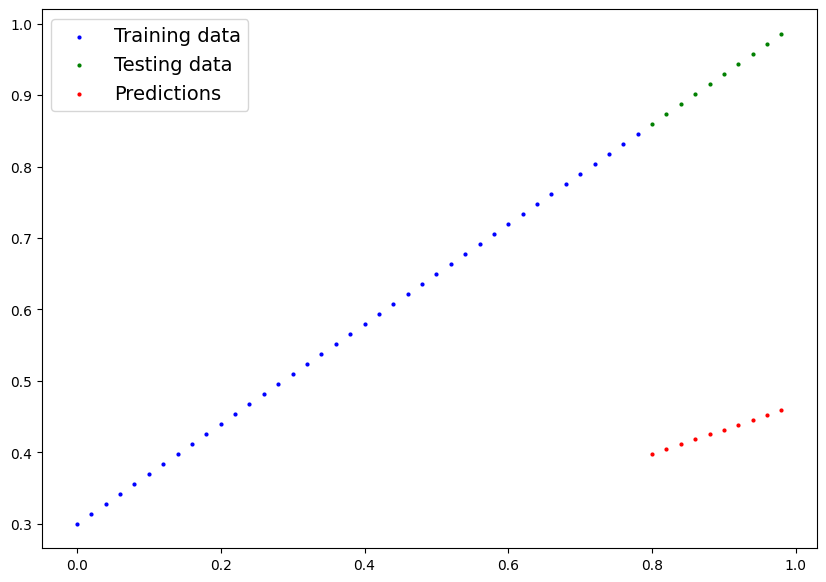

In [56]:
# Plot the predictions
plot_predictions(predictions=y_preds)

 ## 3. Train model

### Firstly we need to create a loss function

In [57]:
# We can use a loss function from torch.nn
loss_fn = nn.L1Loss()
print(loss_fn)

# Setup an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr = 0.01)
print(optimizer)

L1Loss()
SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


### Now we create a training and testing loop

0. Loop throught the data
1. Forward propagation
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward - calculate the gradient of each of the parameter of our model with respect to the loss
5. Optimizer step - adjust our model's parameters to try and improve the loss (**gradient descent**)``

In [58]:
torch.manual_seed(42)
# Number of loops through the data
epochs = 200

# Tracking
epoch_count = []
loss_values = []
test_loss_values = []

# 0. Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # sets all parameters that require gradients to require gradient
                  # it's the opposite of torch.inference_mode() (I believe)

  # 1. Forward propagation
  y_preds = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_preds, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation of the loss
  loss.backward()

  # 5. Step the optimizer
  optimizer.step() # optimizer changes will accumulate through the loop so we need to zero them in step 3


  # Testing
  model_0.eval()

  with torch.inference_mode():
    # 1. Do the forward pass
    test_preds = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_preds, y_test)

    if epoch % 10 == 0:
      epoch_count.append(epoch)
      loss_values.append(loss)
      test_loss_values.append(test_loss)
      print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
Epoch: 70 | Loss: 0.03476089984178543 | Test loss: 0.0805937647819519
Epoch: 80 | Loss: 0.03132382780313492 | Test loss: 0.07232122868299484
Epoch: 90 | Loss: 0.02788739837706089 | Test loss: 0.06473556160926819
Epoch: 100 | Loss: 0.024458957836031914 | Test loss: 0.05646304413676262
Epoch: 110 | Loss: 0.021020207554101944 | Test loss: 0.04819049686193466
Epoch: 120 | Loss: 0.01758546568453312 | Test loss: 0.04060482233762741
Epoch: 130 | Loss: 0.014155393466353416 | Test loss: 0.03233227878808975
Ep

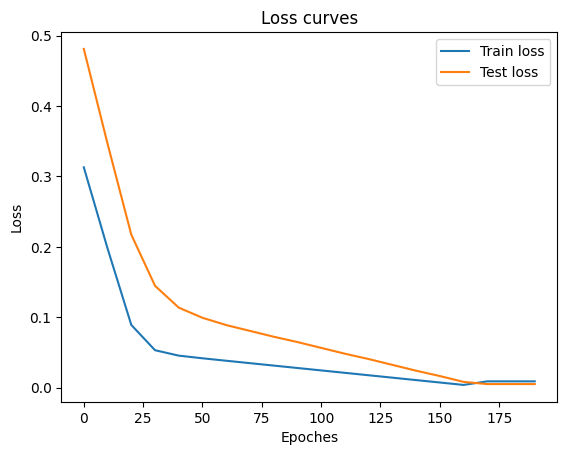

In [59]:
import numpy as np
# Plot the loss curves

plt.plot(epoch_count, np.array(torch.tensor(loss_values)), label="Train loss")
plt.plot(epoch_count, np.array(torch.tensor(test_loss_values)), label="Test loss")
plt.title("Loss curves")
plt.ylabel("Loss")
plt.xlabel("Epoches")
plt.legend()

In [60]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

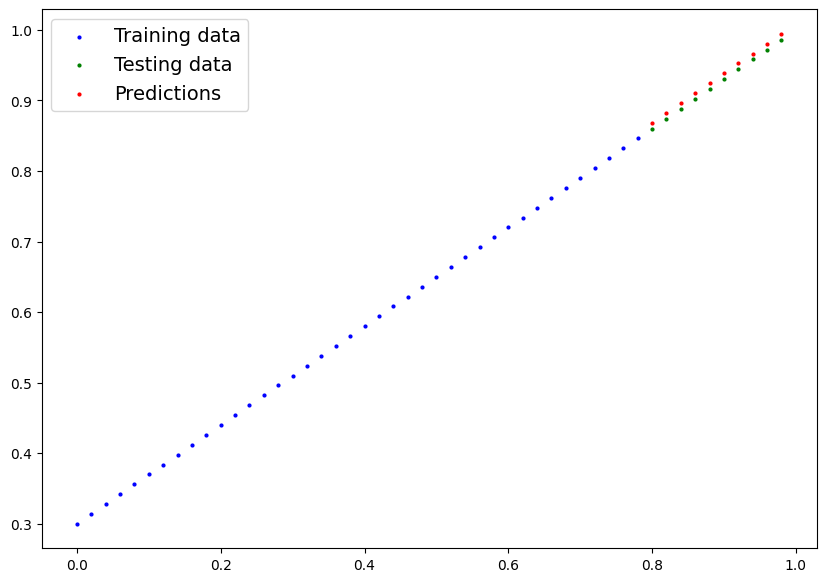

In [61]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)
  plot_predictions(predictions=y_preds_new)

## Save the Model
There are three main methods for saving and loading models in PyTorch.

1. `torch.save()` - saves a model in .pkl type
2. `torch.load()` - loads a model saved as .pkl
3. `torch.nn.Module.load_state_dict()` - allows you to load a model's saved state dictionary

It is recommended to save only the weights and biases

In [64]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = '01_workflow.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state_dict()
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

In [65]:
# Loading back in
loaded_model = LinearRegressionModel()
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH, weights_only=True))
loaded_model.eval()

loaded_model.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [66]:
# Make some predictions
with torch.inference_mode():
  loaded_model_preds = loaded_model(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [68]:
# Compare loaded model preds with original model preds
model_0.eval()
with torch.inference_mode():
  original_model_preds = model_0(X_test)

print(original_model_preds.eq(loaded_model_preds))

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])


## Putting it all together

In [136]:
import torch
import matplotlib.pyplot as plt
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
RANDOM_SEED = 10

### Data

In [137]:
# Create X and y
weight = 0.7
bias = 3

X = torch.arange(0,1,0.02).unsqueeze(dim=1)
y = weight * X + bias

# Split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

print(X_train.size(), y_train.size(), X_test.size(), y_test.size())

torch.Size([40, 1]) torch.Size([40, 1]) torch.Size([10, 1]) torch.Size([10, 1])


In [138]:
# Visualization
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions=None):
  plt.figure(figsize=(10,7))
  plt.scatter(train_data, train_labels, c='b', s=4, label='Train data')
  plt.scatter(test_data, test_labels, c='g', s=4, label='Test data')
  if predictions is not None:
    plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')
  plt.legend(['Train data', 'Test data', 'Predictions'])

### Build the model

In [147]:
class LinearRegressor(nn.Module):
  def __init__(self):
    super().__init__()
    #Using nn.Linear()
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

In [148]:
torch.manual_seed(RANDOM_SEED)
model_1 = LinearRegressor()
model_1.to(device)
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[-0.0838]], device='cuda:0')),
             ('linear_layer.bias', tensor([-0.0343], device='cuda:0'))])

### Loss function and optimizer

In [149]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01)

### Train & Test loop

In [150]:
torch.manual_seed(RANDOM_SEED)
epochs = 1000

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

epoch_count = []
loss_values = []
test_loss_values = []

for epoch in range(epochs):
  model_1.train()

  # 1.
  y_preds = model_1(X_train)

  # 2.
  loss = loss_fn(y_preds, y_train)

  # 3.
  optimizer.zero_grad()

  # 4.
  loss.backward()

  # 5.
  optimizer.step()

  model_1.eval()

  with torch.inference_mode():
    y_test_preds = model_1(X_test)
    test_loss = loss_fn(y_test_preds, y_test)

    if epoch % 100 == 0:
      epoch_count.append(epoch)
      loss_values.append(loss.cpu().detach().numpy())
      test_loss_values.append(test_loss.cpu().detach().numpy())
      print(f'Epoch: {epoch}, Loss: {loss}, Test Loss: {test_loss}')


Epoch: 0, Loss: 3.3399808406829834, Test Loss: 3.7184255123138428
Epoch: 100, Loss: 2.1878814697265625, Test Loss: 2.371325731277466
Epoch: 200, Loss: 1.0357826948165894, Test Loss: 1.024227499961853
Epoch: 300, Loss: 0.06470181792974472, Test Loss: 0.13397125899791718
Epoch: 400, Loss: 0.029526550322771072, Test Loss: 0.06847577542066574
Epoch: 500, Loss: 0.007260030601173639, Test Loss: 0.007221985142678022
Epoch: 600, Loss: 0.007260030601173639, Test Loss: 0.007221985142678022
Epoch: 700, Loss: 0.007260030601173639, Test Loss: 0.007221985142678022
Epoch: 800, Loss: 0.007260030601173639, Test Loss: 0.007221985142678022
Epoch: 900, Loss: 0.007260030601173639, Test Loss: 0.007221985142678022


### Make predictions

In [151]:
with torch.inference_mode():
  y_preds = model_1(X_test)
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7020]], device='cuda:0')),
             ('linear_layer.bias', tensor([2.9920], device='cuda:0'))])

### Plot the results

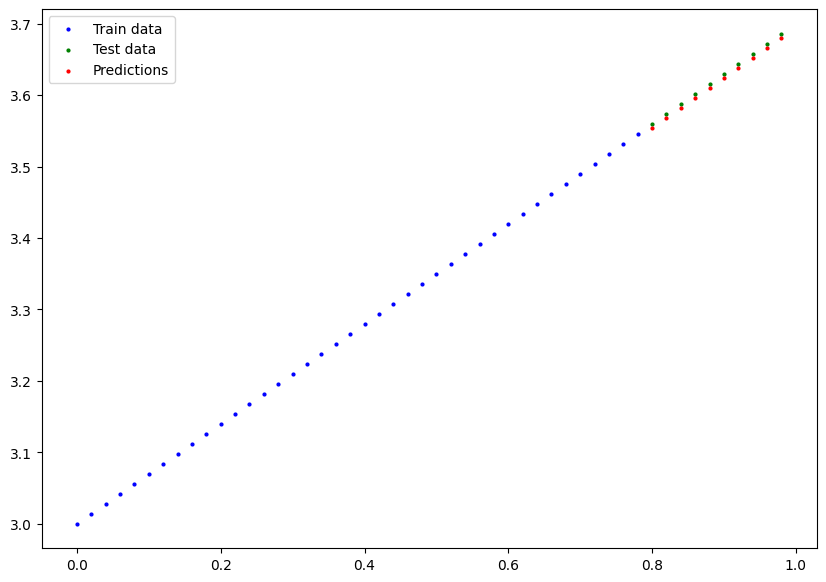

In [152]:
plot_predictions(predictions=y_preds.cpu())

### Visualize the loss

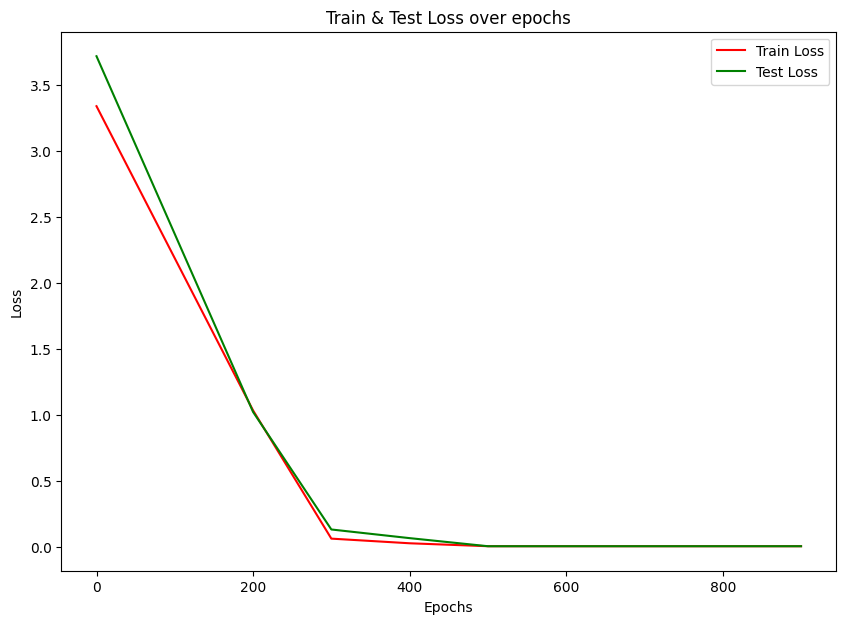

In [153]:
plt.figure(figsize=(10,7))
plt.plot(epoch_count,loss_values, c='r', label='Train Loss')
plt.plot(epoch_count,test_loss_values, c='g', label='Test Loss')
plt.title('Train & Test Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

### Save model

In [154]:
from pathlib import Path
DIRECTORY_PATH = Path('models')
DIRECTORY_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = Path('model1.pth')
SAVE_PATH = DIRECTORY_PATH / MODEL_NAME

torch.save(model_1.state_dict(), SAVE_PATH)